In [5]:
import json 
import numpy as np 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn import tree

In [2]:
with open('intents.json') as file:
    data = json.load(file)

In [1]:
def pad_sequences(sequences,maxlen,padding = 'pre',value=0):
  padding_sequences = sequences
  if padding=='pre':
    for seq in padding_sequences:
      while(len(seq)<maxlen):
        seq.insert(0,value)
  else:
    for seq in padding_sequences:
      while(len(seq)<maxlen):
        seq.append(value)
  return np.array(padding_sequences)





def texts_to_sequences(training_sentences,word_index):
  seq=[]
  bad_char = [',','?','/','_','@','#','*']
  for sentence in training_sentences:
    w=[]
    for c in bad_char:
      sentence = sentence.replace(c,'')
    for word in sentence.split():
      word = word.lower()
      w.append(word_index[word])
    seq.append(w)
  return seq



class label_encoder:

  def __init__(self,training_labels):
    self.training_labels = training_labels
    self.class_array = []
    self.class_labels = []


  def find_class_array(self):
    self.class_array = []
    self.class_labels = []
    idx = 0
    for data in self.training_labels:
      if data not in self.class_array:
        self.class_array.append(data)
        self.class_labels.append(idx)
        idx+=1
    self.class_array = sorted(self.class_array)
    #print(self.class_array)
    

  def Label_Encoder(self):
    num_array = []
    #print(self.class_array)
    d = {self.class_array[i]:self.class_labels[i] for i in range(len(self.class_array))}
    for label in self.training_labels:
      num_array.append(d[label])
    return(np.array(num_array))



  def inverse_transform(similarity_vector,self):
    max_index = None
    max = 0
    for index in range(len(similarity_vector)):
      if max<similarity_vector[index]:
        max_index = index
        max = similarity_vector[index]
    return self.class_array[max_index]

In [2]:
import nltk
#nltk.download('stem',quiet=True)
nltk.download('stopwords', quiet = True)
nltk.download('wordnet',quiet = True)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

stop_words = list(stopwords.words('english'))
print(stop_words)
print(lemmatizer.lemmatize("how"))
if "how" in stop_words:
  print('True')

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [7]:
def remove_stopwords(stop_words,training_sentences):
  new_sentences = []
  for sentence in training_sentences:
    s = ''
    words = sentence.split()
    for word in words:
      #word = word.lower()
      if word not in stop_words:
        word = lemmatizer.lemmatize(word)
        s+=(word+' ')
    s=s.strip()
    new_sentences.append(s)
  return new_sentences

In [8]:
with open('intents.json') as file:
    data = json.load(file)
training_sentences = []
training_labels = []
labels = []
responses = []


for intent in data['intents']:
    for pattern in intent['patterns']:
        training_sentences.append(pattern)
        training_labels.append(intent['tag'])
    responses.append(intent['responses'])
    
    if intent['tag'] not in labels:
        labels.append(intent['tag'])




#removing stopwords
training_sentences = remove_stopwords(stop_words,training_sentences)

print("before encoding : ",training_labels,end = '\n\n')

print("after removing stopwords:")
print("new sentences : ",training_sentences,end = '\n\n')

#encoding training labels
lbl_encoder = label_encoder(training_labels) 
lbl_encoder.find_class_array()
training_labels = lbl_encoder.Label_Encoder()


print("after encoding : ",training_labels)


vocab_size = 1000
embedding_dim = 16
max_len = 20
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token) 
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = texts_to_sequences(training_sentences,word_index)
padded_sequences = pad_sequences(sequences,max_len)

before encoding :  ['greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'goodbye', 'goodbye', 'goodbye', 'thanks', 'thanks', 'thanks', 'thanks', 'about', 'about', 'about', 'name', 'name', 'name', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'createaccount', 'createaccount', 'createaccount', 'createaccount', 'createaccount', 'complaint', 'complaint', 'complaint']

after removing stopwords:
new sentences :  ['Hi', 'Hey', 'Is anyone there?', 'Hello', 'Hay', 'Bye', 'See later', 'Goodbye', 'Thanks', 'Thank', "That's helpful", 'Thanks help', 'Who you?', 'What you?', 'Who are?', 'name', 'I call', 'whats name?', 'Could help me?', 'give hand please', 'Can help?', 'What me?', 'I need support', 'I need help', 'support please', 'I need create new account', 'open new account', 'I want create account', 'create account', 'open new account', 'complaint', 'I want raise complaint', 'complaint service']

after encoding :  [4 4 4 4 4 3 3 3 7 7 7 7 0 0 0 6 6 6 5 5 5 5 5 5 5 2 2 2 2 2 1 1

In [9]:
seq = texts_to_sequences(training_sentences,word_index)
print(seq)

[[19], [20], [21, 22, 23], [24], [25], [26], [27, 28], [29], [9], [30], [31, 32], [9, 4], [10, 11], [12, 11], [10, 33], [13], [2, 34], [35, 13], [36, 4, 14], [37, 38, 15], [39, 4], [12, 14], [2, 5, 16], [2, 5, 4], [16, 15], [2, 5, 6, 7, 3], [17, 7, 3], [2, 18, 6, 3], [6, 3], [17, 7, 3], [8], [2, 18, 40, 8], [8, 41]]


In [10]:
print(padded_sequences)

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 19]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 20]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 21 22 23]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 24]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 25]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 26]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 27 28]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 29]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 30]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 31 32]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  9  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 10 11]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 12 11]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 10 33]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [102]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [103]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 16)            16000     
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
Total params: 16,680
Trainable params: 16,680
Non-trainable params: 0
_________________________________________________________________


In [104]:
epochs = 840
history = model.fit(padded_sequences, np.array(training_labels), epochs=epochs)

Epoch 1/840
2/2 [==============================] - 0s 3ms/step - loss: 2.0771 - accuracy: 0.1515
Epoch 2/840
2/2 [==============================] - 0s 3ms/step - loss: 2.0757 - accuracy: 0.1515
Epoch 3/840
2/2 [==============================] - 0s 2ms/step - loss: 2.0752 - accuracy: 0.1818
Epoch 4/840
2/2 [==============================] - 0s 3ms/step - loss: 2.0746 - accuracy: 0.1515
Epoch 5/840
2/2 [==============================] - 0s 2ms/step - loss: 2.0739 - accuracy: 0.1515
Epoch 6/840
2/2 [==============================] - 0s 3ms/step - loss: 2.0735 - accuracy: 0.1515
Epoch 7/840
2/2 [==============================] - 0s 5ms/step - loss: 2.0730 - accuracy: 0.1515
Epoch 8/840
2/2 [==============================] - 0s 2ms/step - loss: 2.0725 - accuracy: 0.1515
Epoch 9/840
2/2 [==============================] - 0s 2ms/step - loss: 2.0719 - accuracy: 0.1515
Epoch 10/840
2/2 [==============================] - 0s 2ms/step - loss: 2.0714 - accuracy: 0.1515
Epoch 11/840
2/2 [===========

2/2 [==============================] - 0s 6ms/step - loss: 1.7489 - accuracy: 0.3636
Epoch 167/840
2/2 [==============================] - 0s 6ms/step - loss: 1.7445 - accuracy: 0.3636
Epoch 168/840
2/2 [==============================] - 0s 7ms/step - loss: 1.7395 - accuracy: 0.3636
Epoch 169/840
2/2 [==============================] - 0s 5ms/step - loss: 1.7338 - accuracy: 0.3636
Epoch 170/840
2/2 [==============================] - 0s 7ms/step - loss: 1.7287 - accuracy: 0.3636
Epoch 171/840
2/2 [==============================] - 0s 6ms/step - loss: 1.7248 - accuracy: 0.3636
Epoch 172/840
2/2 [==============================] - 0s 7ms/step - loss: 1.7213 - accuracy: 0.4545
Epoch 173/840
2/2 [==============================] - 0s 6ms/step - loss: 1.7164 - accuracy: 0.4545
Epoch 174/840
2/2 [==============================] - 0s 6ms/step - loss: 1.7110 - accuracy: 0.4545
Epoch 175/840
2/2 [==============================] - 0s 7ms/step - loss: 1.7060 - accuracy: 0.4545
Epoch 176/840
2/2 [=====

2/2 [==============================] - 0s 3ms/step - loss: 1.0426 - accuracy: 0.6364
Epoch 331/840
2/2 [==============================] - 0s 3ms/step - loss: 1.0359 - accuracy: 0.6667
Epoch 332/840
2/2 [==============================] - 0s 2ms/step - loss: 1.0301 - accuracy: 0.6667
Epoch 333/840
2/2 [==============================] - 0s 2ms/step - loss: 1.0246 - accuracy: 0.6364
Epoch 334/840
2/2 [==============================] - 0s 2ms/step - loss: 1.0200 - accuracy: 0.5758
Epoch 335/840
2/2 [==============================] - 0s 2ms/step - loss: 1.0151 - accuracy: 0.5758
Epoch 336/840
2/2 [==============================] - 0s 2ms/step - loss: 1.0098 - accuracy: 0.6364
Epoch 337/840
2/2 [==============================] - 0s 3ms/step - loss: 1.0059 - accuracy: 0.6364
Epoch 338/840
2/2 [==============================] - 0s 2ms/step - loss: 1.0015 - accuracy: 0.6364
Epoch 339/840
2/2 [==============================] - 0s 3ms/step - loss: 0.9974 - accuracy: 0.6364
Epoch 340/840
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.5643 - accuracy: 0.7879
Epoch 495/840
2/2 [==============================] - 0s 2ms/step - loss: 0.5621 - accuracy: 0.7879
Epoch 496/840
2/2 [==============================] - 0s 3ms/step - loss: 0.5596 - accuracy: 0.7879
Epoch 497/840
2/2 [==============================] - 0s 2ms/step - loss: 0.5567 - accuracy: 0.7879
Epoch 498/840
2/2 [==============================] - 0s 3ms/step - loss: 0.5544 - accuracy: 0.7879
Epoch 499/840
2/2 [==============================] - 0s 3ms/step - loss: 0.5525 - accuracy: 0.7879
Epoch 500/840
2/2 [==============================] - 0s 3ms/step - loss: 0.5504 - accuracy: 0.7879
Epoch 501/840
2/2 [==============================] - 0s 2ms/step - loss: 0.5493 - accuracy: 0.7879
Epoch 502/840
2/2 [==============================] - 0s 2ms/step - loss: 0.5489 - accuracy: 0.8182
Epoch 503/840
2/2 [==============================] - 0s 3ms/step - loss: 0.5478 - accuracy: 0.8788
Epoch 504/840
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.3085 - accuracy: 0.9394
Epoch 659/840
2/2 [==============================] - 0s 3ms/step - loss: 0.3107 - accuracy: 0.9394
Epoch 660/840
2/2 [==============================] - 0s 3ms/step - loss: 0.3134 - accuracy: 0.9394
Epoch 661/840
2/2 [==============================] - 0s 2ms/step - loss: 0.3151 - accuracy: 0.9394
Epoch 662/840
2/2 [==============================] - 0s 2ms/step - loss: 0.3157 - accuracy: 0.9394
Epoch 663/840
2/2 [==============================] - 0s 3ms/step - loss: 0.3163 - accuracy: 0.9091
Epoch 664/840
2/2 [==============================] - 0s 2ms/step - loss: 0.3165 - accuracy: 0.9091
Epoch 665/840
2/2 [==============================] - 0s 2ms/step - loss: 0.3159 - accuracy: 0.9091
Epoch 666/840
2/2 [==============================] - 0s 2ms/step - loss: 0.3128 - accuracy: 0.9091
Epoch 667/840
2/2 [==============================] - 0s 2ms/step - loss: 0.3064 - accuracy: 0.9394
Epoch 668/840
2/2 [=====

2/2 [==============================] - 0s 4ms/step - loss: 0.1251 - accuracy: 1.0000
Epoch 823/840
2/2 [==============================] - 0s 3ms/step - loss: 0.1257 - accuracy: 1.0000
Epoch 824/840
2/2 [==============================] - 0s 2ms/step - loss: 0.1248 - accuracy: 1.0000
Epoch 825/840
2/2 [==============================] - 0s 3ms/step - loss: 0.1231 - accuracy: 1.0000
Epoch 826/840
2/2 [==============================] - 0s 3ms/step - loss: 0.1211 - accuracy: 1.0000
Epoch 827/840
2/2 [==============================] - 0s 3ms/step - loss: 0.1191 - accuracy: 1.0000
Epoch 828/840
2/2 [==============================] - 0s 2ms/step - loss: 0.1191 - accuracy: 1.0000
Epoch 829/840
2/2 [==============================] - 0s 3ms/step - loss: 0.1202 - accuracy: 1.0000
Epoch 830/840
2/2 [==============================] - 0s 2ms/step - loss: 0.1216 - accuracy: 1.0000
Epoch 831/840
2/2 [==============================] - 0s 2ms/step - loss: 0.1228 - accuracy: 1.0000
Epoch 832/840
2/2 [=====

In [13]:
# saving model
#model.save("chat_model_1")

import pickle

# saving tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=4)
    

# saving label encoder
with open('label_encoder.pickle', 'wb') as ecn_file:
    pickle.dump(lbl_encoder, ecn_file, protocol=4)

INFO:tensorflow:Assets written to: chat_model_1\assets


In [105]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


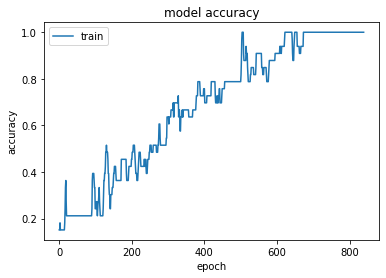

In [106]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
#plt.plot(model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

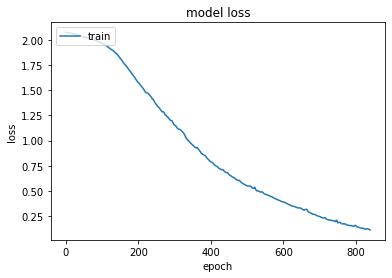

In [107]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [32]:
def entropy(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])

In [33]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

In [84]:
class DecisionTree:

    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping criteria
        if (depth >= self.max_depth
                or n_labels == 1
                or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # greedily select the best split according to information gain
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)
        
        # grow the children that result from the split
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        # parent loss
        parent_entropy = entropy(y)

        # generate split
        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # compute the weighted avg. of the loss for the children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        # information gain is difference in loss before vs. after split
        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

In [88]:
clf = DecisionTree(max_depth=4)

In [ ]:
clf_1 = clf.fit(padded_sequences, np.array(training_labels))

In [63]:
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred)/len(y_true)
    return accuracy

In [64]:
y_pred = clf.predict(padded_sequences)

In [65]:
acc = accuracy( np.array(training_labels), y_pred)

In [66]:
print("Accuracy of Decision Tree Model : " , acc*100, "%")

Accuracy of Decision Tree Model :  87.87878787878788 %


In [19]:
Pkl_Filename = "Decision_tree.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(clf, file)

In [67]:
import random
def random_features(X_train, l):
    orig_features = list(X_train.columns)
    random_features = random.sample(orig_features,k=l)
  
    return random_features

In [ ]:
n = int(input("Enter the number of trees"))
len = int(input("Enter the minimum features you want"))
trees = []
feature = []
for i in range(n):
    features = random_features(padded_sequences,len+i)
    feature.append(features)
    clf = DecisionTreeClassifier()
    clf.fit(padded_sequences[features].values.astype('float'), y_train.values.astype('float'))
    trees.append(clf)

In [73]:
clf_forest=RandomForestClassifier(n_estimators=100,max_depth=4)

In [ ]:
accu = []
i=0
for clf in trees:
    features = feature[i]
    i+=1
    predictions = clf.predict(X_test[features].values)
  
    y_pred= []
    for row_number in range(predictions.shape[0]):
        y_pred.append(np.mean(predictions[row_number, ]))
    y_pred = np.array(y_pred)
    acc = clf.score(X_test[features].values,y_test.values)
    # arr = y_pred - y_test.values
    # accuracy = np.count_nonzero(arr==0)/(y_pred.shape[0])
    accu.append(acc)

In [74]:
clf_forest_class =  clf_forest.fit(padded_sequences,np.array(training_labels))

In [75]:
result_random_forest = clf_forest_class.score(padded_sequences, np.array(training_labels))

In [76]:
print("Accuracy of Random Forest Model : " , result_random_forest*100, "%")

Accuracy of Random Forest Model :  96.96969696969697 %


In [ ]:
Pkl_Filename = "Random_Forest.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(clf_forest, file)

In [108]:
gnb = GaussianNB()

In [109]:
y_pred = gnb.fit(padded_sequences,np.array(training_labels))

In [110]:
result = y_pred.score(padded_sequences, np.array(training_labels))

In [111]:
print("Accuracy of Naive Bayes Model : " , result*100, "%")

Accuracy of Naive Bayes Model :  66.66666666666666 %
